# XGBoost Model for Graduate Admissions & Feature Importance

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score

from xgboost import XGBClassifier
import shap

**Variables**

1. GRE Scores ( out of 340 )
2. TOEFL Scores ( out of 120 )
3. University Rating ( out of 5 )
4. Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
5. Undergraduate GPA ( out of 10 )
6. Research Experience ( either 0 or 1 )
7. Chance of Admit ( ranging from 0 to 1 )

### Preprocessing

In [5]:
df = pd.read_csv('Admission_Predict.csv')

target = []
for i in df.iloc[:,-1]:
    if i > 0.5:
        target.append(1)
    else:
        target.append(0)

df['target'] = target

In [6]:
df.drop(['Serial No.', 'University Rating', 'Chance of Admit '], axis=1, inplace=True)
for i in df['CGPA']:
    if (i > 9 or i < 8):
        df.drop(df[df['CGPA'] == i].index, inplace=True)

### Constructing XGBoost Model

In [7]:
X = df.drop('target', axis=1)
y = df.target

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

weight = (len(ytrain) - sum(ytrain))/sum(ytrain)

In [8]:
model = XGBClassifier(scale_pos_weight=weight, random_state=0)

In [9]:
param_grid = dict({'n_estimators'  : [50,100,150,250,300,250], 
                   'max_depth'     : [3, 4, 5],
                   'learning_rate' : [0.001, 0.01, 0.1]
                  })


GridXGB = GridSearchCV(model,       
                       param_grid=param_grid,          
                       cv=5,      
                       scoring = 'roc_auc', 
                       n_jobs = -1,          
                       refit = True,       
                       verbose = 1
                      )

GridXGB.fit(Xtrain, ytrain)

best_parameters = GridXGB.best_params_

print(best_parameters)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}


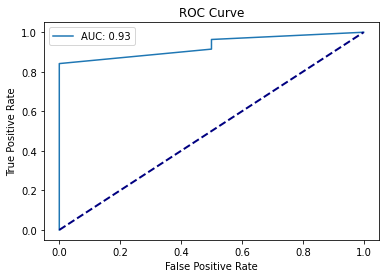

In [10]:
best_model = XGBClassifier(n_estimators=50,
                          learning_rate=0.001,
                          max_depth=3,
                          scale_pos_weight=weight,
                          random_state=0)

best_model.fit(Xtrain, ytrain)

ypred = best_model.predict_proba(Xtest)
ypred = ypred[:,1]

fpr, tpr, thresholds = roc_curve(ytest, ypred)

auc = roc_auc_score(y_true=ytest, y_score=ypred)

plt.plot(fpr,tpr,label="AUC: {}".format(auc.round(3)))
plt.legend()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Feature importance

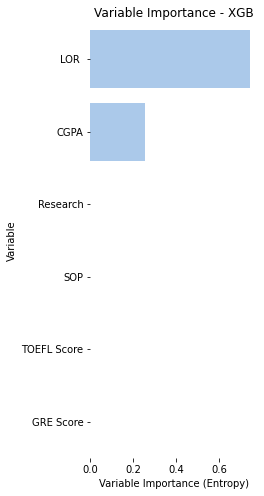

In [11]:
# Plotting variable importance plot by entropy

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGB")
sns.set_color_codes("pastel")
sns.barplot(y=[Xtrain.columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


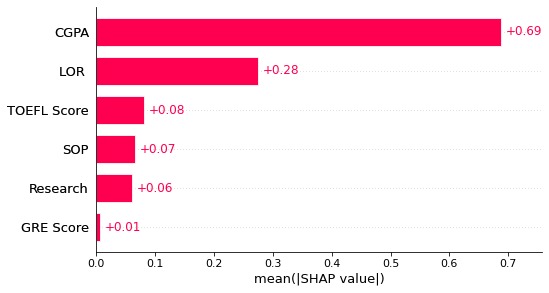

In [12]:
# Plotting variable importance plot by mean-shap value

explainer = shap.Explainer(GridXGB.best_estimator_)
shap_values = explainer(Xtest)

shap.plots.bar(shap_values)

There are more variables in the second plot because the model might rely on a combination of CGPA, LOR, TOEFL, SOP, etc. to make accurate predictions. On the other hand, the plot by Entropy may not capture this joint effect and rank features based on their individual effect on reducing impurity. This is why there are so many more variables in the second plot, because graduate admission boards usually look at everything together.

### Interpretation using SHAP values

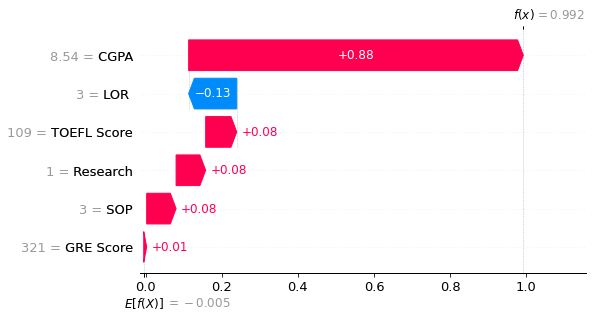

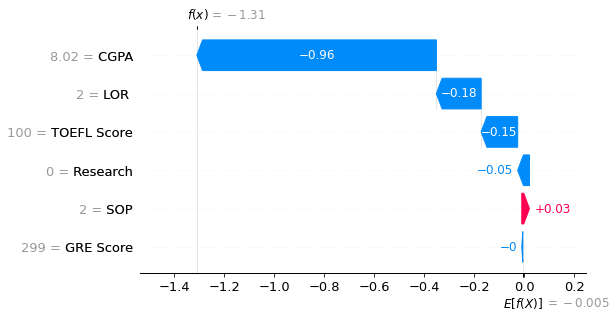

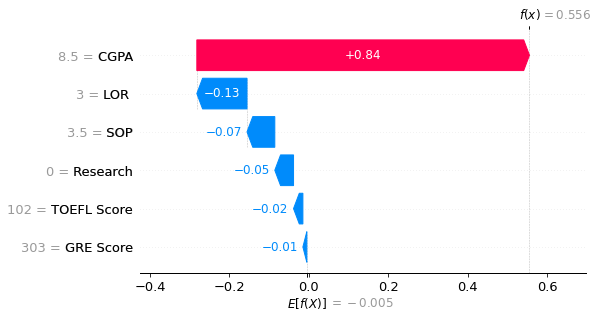

In [13]:
# Feature contribution plot for first, third, and fourth cases

case_indices = [0, 2, 3]
for i in case_indices:
    shap.plots.waterfall(shap_values[i])
    plt.show()

- Based on the three cases, it seems like there is a CGPA cutoff between 8.02 and 8.54
- If a LOR is not above average, it will reduce chances of admission
- A good score for TOEFL is between 100 and 109
- Having research experience or not contributes very little to admission decision (same for GRE)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


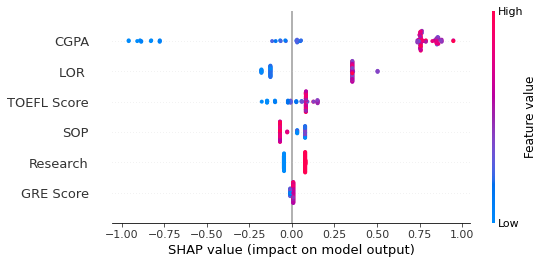

In [14]:
# Summarizing the effects of all features by using a beeswarm plot

shap.plots.beeswarm(shap_values)

The first three features are CGPA, LOR, and TOEFL Score. A very high or very low CGPA contributes most to admission decision whereas an average or slightly below average CGPA has low impact on the model. A good LOR has a much bigger impact on model output than a low LOR which has a very small impact. The impact of TOEFL score on the model is much more varied depending on the applicant. This is likely due to the fact that TOEFL scores are considered in combination with other features like CGPA and TOEFL.

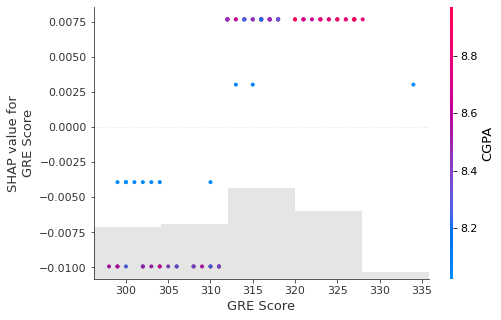

In [15]:
# Plotting SHAP-value dependence scatter plot to show effect of "GRE Score" across whole dataset

shap.plots.scatter(shap_values[:,"GRE Score"], color=shap_values)

GRE scores are only somewhat important for predicting when very low or very high. Also to be somewhat important as a predictor, the CGPA should also be somewhat high whether GRE score is high or low.

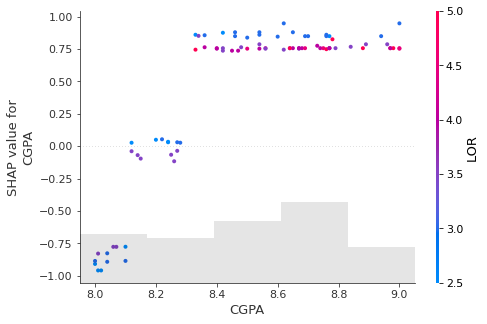

In [16]:
# Plotting SHAP-value dependence scatter plot to show effect of "GRE Score" across whole dataset

shap.plots.scatter(shap_values[:,"CGPA"], color=shap_values)

An average CGPA around 8.1 to 8.3 is not a good predictor for the model. Only CGPAs on the lower end below 8.1 and above 8.3 are useful in predicting graduate admission. Higher CGPAs are also accompanied by higher LOR but not always. Those that had a lower LOR relied alot more on CGPA to get them admitted and that is reflected in the importance of CGPA for those students.